**Version Summary**

**Download dependencies / libraries**

In [ ]:
from google.colab import drive
drive.mount('your google drive path')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow-gpu==2.0.0-rc0

In [ ]:
## Import usual libraries
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import *
from tensorflow.keras import optimizers
import numpy as np
import matplotlib.pyplot as plt

**Make Datasets**

Makes numpy datasets from png images and coco annotations. 
- requires correct data_path and coco path
- saves it into X and Y folder like so:


```
-- data_dir/
   -- X/                      -- Y/
      -- RGBDF_00000001.npy      -- GT_00000001.npy
      -- RGBDF_00000002.npy      -- GT_00000002.npy
```


In [ ]:
# download data and prepare X and Y ahead of time
# Only thing you need is coco json file and data_path, and you are good to go

from pycocotools.coco import COCO
import numpy as np
import cv2
import os

# path names
data_path = 'directory of your dataset (json)'
coco=COCO(data_path+'RGBDF.json')

""" FOR Y """

# make directory to store data
new_dir = "./Y"
if not os.path.exists(new_dir): os.mkdir(new_dir)
tensor_shape = (557,557,10)

# image_RGB_0000XXXX.npy for 194 images
for i in range(1,195):

    # fetch names & id from coco
    image_name = "image_IR_"+str(i+100000000)[1:]+".png"
    imgIds = [imageId for imageId in coco.getImgIds() if coco.loadImgs(imageId)[0]['file_name'] == image_name]

    # Y box of 720x1280x18 (hxwxd)
    Y = np.zeros(tensor_shape)
    Y = np.bool_(Y) # reduce size from float64 to bool

    # pull out annotations
    annIds = coco.getAnnIds(imgIds=imgIds, iscrowd=None)
    anns = coco.loadAnns(annIds)

    # mark Y with annotation
    Y = np.moveaxis(Y,-1,0) # 18x720x1280
    cat_index = {14: 1, 11: 2, 12: 3, 13: 4, 15: 5, 16: 6, 17: 7, 18: 8, 19: 9}
    for ann in anns:
        Y[cat_index[ann['category_id']]] = coco.annToMask(ann) # idx557x557 = 557x557
    Y[0] = np.sum(Y,axis=0)-1 # tile (remaining zeros)
    Y = np.moveaxis(Y,0,-1) # 557x557x9

    # save Y
    save_path = "GT_"+str(i).zfill(8)
    img_path = "Y_"+coco.loadImgs(imgIds)[0]['file_name']
    print(img_path)
    np.save(new_dir+"/"+save_path,Y)

""" FOR X """

# make directory to store data
new_dir = "./X"
if not os.path.exists(new_dir): os.mkdir(new_dir)
input_shape = (557,557)

# image_RGB_0000XXXX.npy for 1800 images
for i in range(1,195):

    # fetch names & id from coco
    image_name = "image_IR_"+str(i+100000000)[1:]+".png"
    imgIds = [imageId for imageId in coco.getImgIds() if coco.loadImgs([imageId])[0]['file_name'] == image_name] #finding imageID with image_name
    img_path = data_path + coco.loadImgs(imgIds)[0]['path'][16:]
    depth_path = img_path[:-len(coco.loadImgs(imgIds)[0]['file_name'])] + "image_DEPTH_" + coco.loadImgs(imgIds)[0]['file_name'][-12:]

    # Let's make X box of 557 x 557 x 5 (hxwxd)

    #get rgb and depth
    RGB = cv2.imread(img_path)
    D = cv2.imread(depth_path, 6) # 6 means reading depth file
    if RGB is None:
        print("missing " + img_path)
        continue
    if D is None:
        print("missing " + depth_path)
        continue

    # get friction
    F = np.float32(np.zeros(input_shape))
    anns = coco.loadAnns(coco.getAnnIds(imgIds=imgIds, iscrowd=None)) #getting annotations' description
    for ann in anns:
        if ann['category_id'] == 14: F += coco.annToMask(ann)* np.random.normal(0.723, 0.054, 1)[0] * 0.33333; continue # special plastic treatment
        coef = ann['friction_coeff'][str(ann['category_id'])]
        F += coco.annToMask(ann)*coef
    
    # adding tile coeffcient
    tile_coeff = np.random.normal(0.717, 0.063, 1)[0] * 0.33333
    F[F == 0] = tile_coeff # everything else is tile

    # merge rgb, depth, friction
    RGB = np.moveaxis(RGB,-1,0) # shape 3x720x1280
    X = np.append(RGB,[D],axis=0) # shape 4x720x1280
    X = np.append(X,[F],axis=0) # shape 5x720x1280
    X = np.moveaxis(X,0,-1) # shape 720x1280x5

    # save X
    save_path = "RGBDF_"+str(i).zfill(8)
    img_path = "X_"+coco.loadImgs(imgIds)[0]['file_name']
    print(img_path)
    np.save(new_dir+"/"+save_path,X)




loading annotations into memory...
Done (t=4.66s)
creating index...
index created!
Y_image_IR_00000001.png
Y_image_IR_00000002.png
Y_image_IR_00000003.png
Y_image_IR_00000004.png
Y_image_IR_00000005.png
Y_image_IR_00000006.png
Y_image_IR_00000007.png
Y_image_IR_00000008.png
Y_image_IR_00000009.png
Y_image_IR_00000010.png
Y_image_IR_00000011.png
Y_image_IR_00000012.png
Y_image_IR_00000013.png
Y_image_IR_00000014.png
Y_image_IR_00000015.png
Y_image_IR_00000016.png
Y_image_IR_00000017.png
Y_image_IR_00000018.png
Y_image_IR_00000019.png
Y_image_IR_00000020.png
Y_image_IR_00000021.png
Y_image_IR_00000022.png
Y_image_IR_00000023.png
Y_image_IR_00000024.png
Y_image_IR_00000025.png
Y_image_IR_00000026.png
Y_image_IR_00000027.png
Y_image_IR_00000028.png
Y_image_IR_00000029.png
Y_image_IR_00000030.png
Y_image_IR_00000031.png
Y_image_IR_00000032.png
Y_image_IR_00000033.png
Y_image_IR_00000034.png
Y_image_IR_00000035.png
Y_image_IR_00000036.png
Y_image_IR_00000037.png
Y_image_IR_00000038.png
Y_ima

**Load Dataset:** load dataset into X and Y variable


*   Must run **Make Dataset** before running **Load Dataset**
*   This is also where you make following adjustment:
  1.   **Separate** test and train set according to "selection list"
  2.   **Resize** Dataset into specific shape





In [ ]:
from os import listdir

# our data
input_shape = (512,512,4)
n_classes = 10

# loading data for all 194
Xlist = listdir("./X")
Ylist = listdir("./Y")
Ylist.sort()
Xlist.sort()

X = np.stack([np.load("./X/"+i) for i in Xlist])
Y = np.stack([np.load("./Y/"+i) for i in Ylist])

# separate into train & test
selection = [1,6,11,16,21,26,31,36,171,137,104,70]
testSet = [x-1 for x in selection] # fix indexing (starts form 0)
trainSet = [x for x in range(194) if x not in testSet]

testX = X[testSet,(557-input_shape[0])>>1:(557+input_shape[0])>>1,(557-input_shape[1])>>1:(557+input_shape[1])>>1,:input_shape[2]]
testY = Y[testSet,(557-input_shape[0])>>1:(557+input_shape[0])>>1,(557-input_shape[1])>>1:(557+input_shape[1])>>1,:n_classes]
trainX = X[trainSet,(557-input_shape[0])>>1:(557+input_shape[0])>>1,(557-input_shape[1])>>1:(557+input_shape[1])>>1,:input_shape[2]]
trainY = Y[trainSet,(557-input_shape[0])>>1:(557+input_shape[0])>>1,(557-input_shape[1])>>1:(557+input_shape[1])>>1,:n_classes]


print("train shape:",trainX.shape,trainY.shape)
print("test  shape:", testX.shape, testY.shape)


train shape: (182, 512, 512, 4) (182, 512, 512, 10)
test  shape: (12, 512, 512, 4) (12, 512, 512, 10)


**Batch generator**: makes batch from saved npys. augment & crop data as needed  
- **augment** = True, generates augmented data
- change **input_shape**, **n_classes** to crop
- **shuffles** = True shuffles data
- requires location of npy directories (should be done automatically)


In [ ]:
import numpy as np
import cv2
from tensorflow.python.keras.utils.data_utils import Sequence
from keras_preprocessing.image import apply_affine_transform
from keras_preprocessing.image import apply_brightness_shift
import random

class BatchGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, X, Y, batch_size=10, epoch_size=len(X), shuffle=False, augment=False):
        'Initialization'
        self.X = X
        self.Y = Y
        self.x = np.zeros((batch_size, *X.shape[1:]),dtype=np.float32)
        self.y = np.zeros((batch_size, *Y.shape[1:]),dtype=np.bool_)
        self.epoch_size = epoch_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.len = int(np.floor(self.epoch_size / self.batch_size))
        
        self.indexes = np.arange(epoch_size,dtype=np.uint8)
        self.index = np.zeros(batch_size,dtype=np.uint8)

        self.randompull = epoch_size != len(X)
        self.on_epoch_end()
        

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.len

    def __getitem__(self, index):
        'Generate one batch of data'
        
        #update index
        self.index[:] = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        if self.randompull: 
          for i in range(self.batch_size): self.index[i] = random.randint(0,len(self.X)-1)

        # Generate Data
        self.generate_data()

        # augment Data
        if self.augment: self.augment_data()
        
        return self.x, self.y
        

    # ---- self made code from here ----
    def on_epoch_end(self):
        'called once at the very beginning'
        if self.shuffle: random.shuffle(self.indexes)

    def generate_data(self,):
        'populate data to be sent (x,y) from X and Y according to index'
        k = 0
        for i in self.index:
          self.x[k] = self.X[i]
          self.y[k] = self.Y[i]
          k += 1


    def augment_data(self):
        'augment data x and y'
        #rotation = theta
        #shift = tx, ty
        #zoom = zx, zy  >1 small, <1 big
        #shear = shear
        #brightness = brightness <1 dark, >1 bright
        #order = order of interpolation, 0 is best (tried myself)
        
        for i in range(len(self.x)):
            # default
            theta = tx = ty = shear = 0
            brightness = zx = zy = 1
        
            # set parameter range
            theta = random.uniform(0, 360)
            # tx = random.uniform(-self.input_shape[0]/3,self.input_shape[0]/3)
            # ty = random.uniform(-self.input_shape[1]/3,self.input_shape[1]/3)
            # zx = zy = pow(2,random.uniform(-0.5,0))
            brightness = pow(2,random.uniform(-0.5,0.3))
            
            # apply augmentation
            self.x[i] = apply_affine_transform(self.x[i], theta=theta, tx=tx, ty=ty, shear=0, zx=zx, zy=zy,order=0,fill_mode='reflect')
            self.y[i] = apply_affine_transform(self.y[i], theta=theta, tx=tx, ty=ty, shear=0, zx=zx, zy=zy,order=0,fill_mode='reflect')
            self.x[i,:,:,:3] = apply_brightness_shift(self.x[i,:,:,:3], brightness=brightness)


X: (8, 448, 448, 4)  Y: (8, 448, 448, 9)


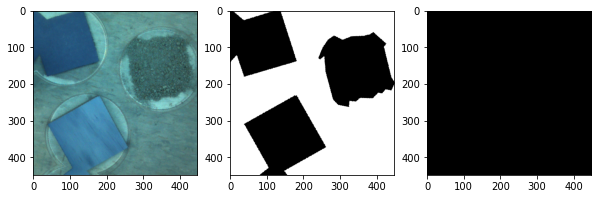

X: (8, 448, 448, 4)  Y: (8, 448, 448, 9)


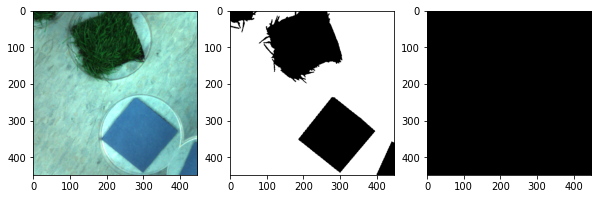

X: (8, 448, 448, 4)  Y: (8, 448, 448, 9)


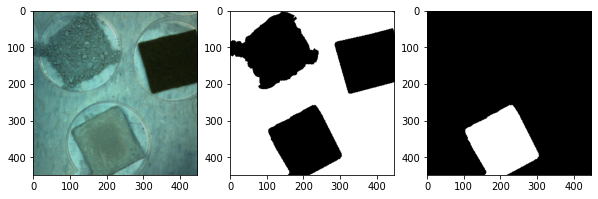

X: (8, 448, 448, 4)  Y: (8, 448, 448, 9)


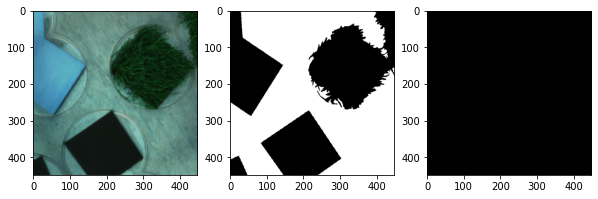

X: (8, 448, 448, 4)  Y: (8, 448, 448, 9)


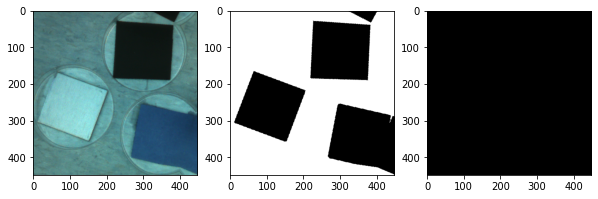

X: (8, 448, 448, 4)  Y: (8, 448, 448, 9)


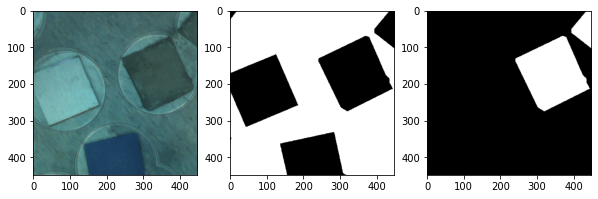

X: (8, 448, 448, 4)  Y: (8, 448, 448, 9)


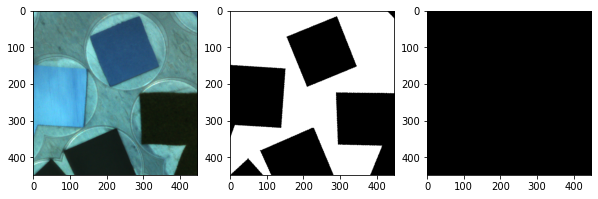

X: (8, 448, 448, 4)  Y: (8, 448, 448, 9)


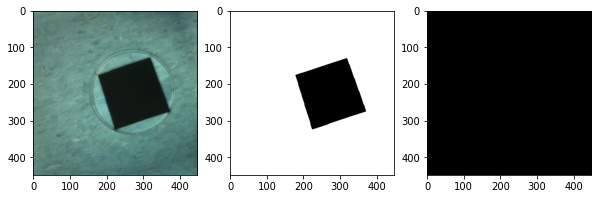

X: (8, 448, 448, 4)  Y: (8, 448, 448, 9)


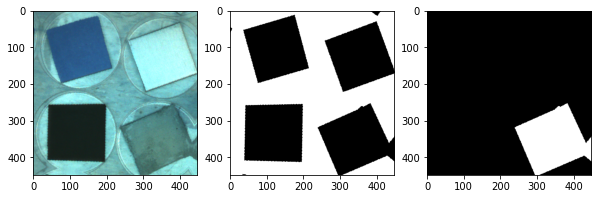

X: (8, 448, 448, 4)  Y: (8, 448, 448, 9)


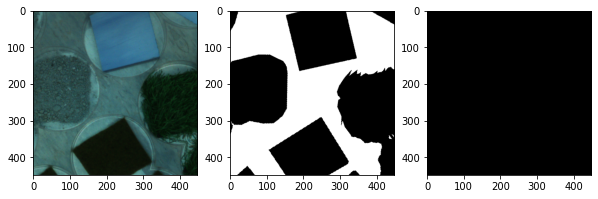

X: (8, 448, 448, 4)  Y: (8, 448, 448, 9)


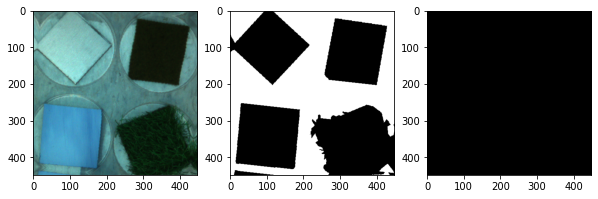

X: (8, 448, 448, 4)  Y: (8, 448, 448, 9)


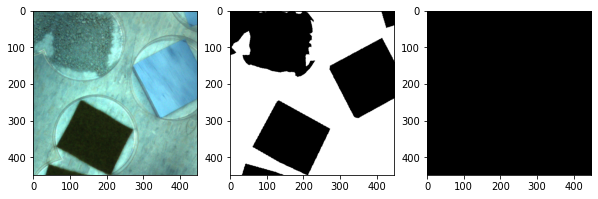

X: (8, 448, 448, 4)  Y: (8, 448, 448, 9)


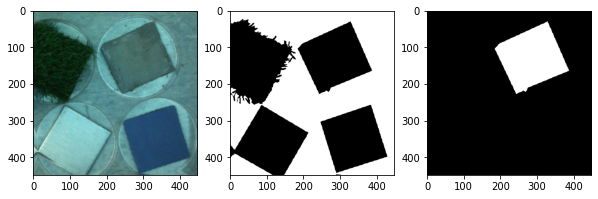

X: (8, 448, 448, 4)  Y: (8, 448, 448, 9)


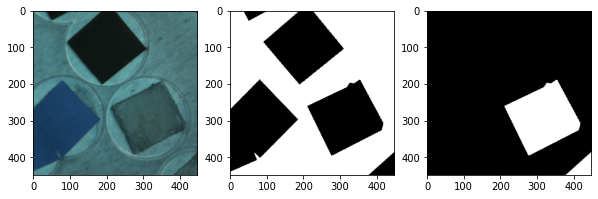

X: (8, 448, 448, 4)  Y: (8, 448, 448, 9)


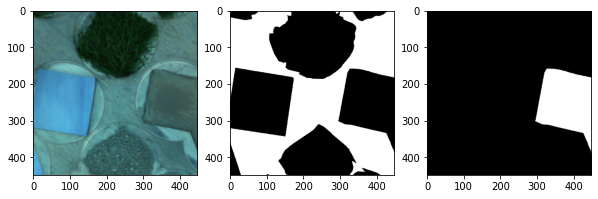

X: (8, 448, 448, 4)  Y: (8, 448, 448, 9)


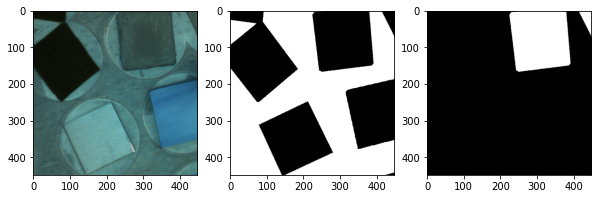

X: (8, 448, 448, 4)  Y: (8, 448, 448, 9)


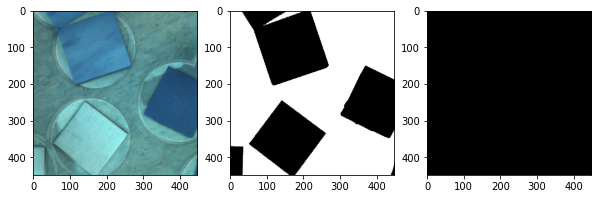

X: (8, 448, 448, 4)  Y: (8, 448, 448, 9)


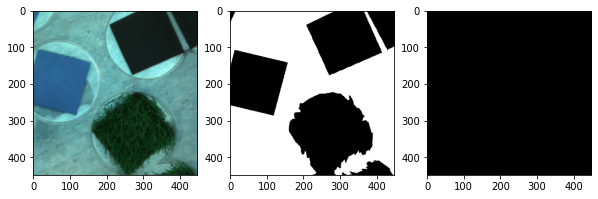

X: (8, 448, 448, 4)  Y: (8, 448, 448, 9)


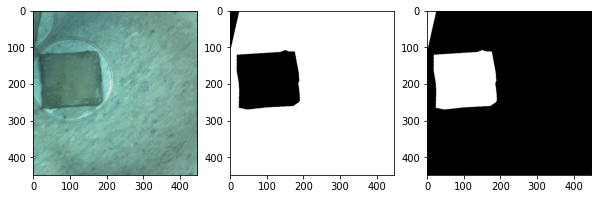

X: (8, 448, 448, 4)  Y: (8, 448, 448, 9)


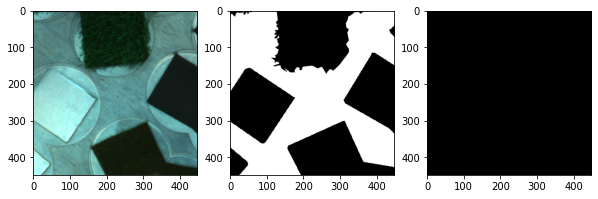

X: (8, 448, 448, 4)  Y: (8, 448, 448, 9)


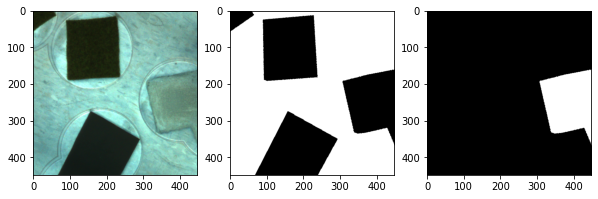

X: (8, 448, 448, 4)  Y: (8, 448, 448, 9)


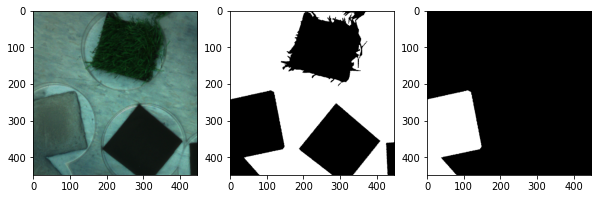

X: (8, 448, 448, 4)  Y: (8, 448, 448, 9)


KeyboardInterrupt: ignored

In [ ]:
# Sanity check on BatchGenerator
gen = BatchGenerator(trainX,trainY, batch_size=8, epoch_size=200, augment=True, shuffle=True)

for x,y in gen:
    print("X:",x.shape," Y:",y.shape)
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,3,1); ax.imshow(x[1,:,:,:3]/255)
    ax = fig.add_subplot(1,3,2); ax.imshow(y[1,:,:,0],cmap='gray')
    ax = fig.add_subplot(1,3,3); ax.imshow(y[1,:,:,4],cmap='gray')
    plt.show()

**Build ML Network:** FCN and Unet

In [ ]:
def FCN(input_shape, f):
    
    AC = LeakyReLU(alpha=0.001) #0 means not leaky
    X_Input = Input(input_shape)
    X = BatchNormalization()(X_Input)

    # 1 block
    X = Conv2D(filters=64, kernel_size=(3,3), activation=AC, padding='same') (X)
    X = Conv2D(filters=64, kernel_size=(3,3), activation=AC, padding='same', kernel_initializer='he_uniform') (X)
    X = BatchNormalization()(X)
    X = MaxPool2D(2,2) (X)

    # 2 block
    X = Conv2D(filters=128, kernel_size=(3,3), activation=AC, padding='same', kernel_initializer='he_uniform') (X)
    X = Conv2D(filters=128, kernel_size=(3,3), activation=AC, padding='same', kernel_initializer='he_uniform') (X)
    X = BatchNormalization()(X)
    X = MaxPool2D(2,2) (X)

    # 3 block
    X = Conv2D(filters=256, kernel_size=(3,3), activation=AC, padding='same', kernel_initializer='he_uniform') (X)
    X = Conv2D(filters=256, kernel_size=(3,3), activation=AC, padding='same', kernel_initializer='he_uniform') (X)
    X = Conv2D(filters=256, kernel_size=(3,3), activation=AC, padding='same', kernel_initializer='he_uniform') (X)
    X = BatchNormalization()(X)
    X = MaxPool2D(2,2) (X)
    X3 = X

    # 4 block
    X = Conv2D(filters=512, kernel_size=(3,3), activation=AC, padding='same', kernel_initializer='he_uniform') (X)
    X = Conv2D(filters=512, kernel_size=(3,3), activation=AC, padding='same', kernel_initializer='he_uniform') (X)
    X = Conv2D(filters=512, kernel_size=(3,3), activation=AC, padding='same', kernel_initializer='he_uniform') (X)
    X = BatchNormalization()(X)
    X = MaxPool2D(2,2) (X)
    X4 = X

    # 5 block
    X = Conv2D(filters=512, kernel_size=(3,3), activation=AC, padding='same', kernel_initializer='he_uniform') (X)
    X = Conv2D(filters=512, kernel_size=(3,3), activation=AC, padding='same', kernel_initializer='he_uniform') (X)
    X = Conv2D(filters=512, kernel_size=(3,3), activation=AC, padding='same', kernel_initializer='he_uniform') (X)
    X = BatchNormalization()(X)
    X = MaxPool2D(2,2) (X)

    # 6 conv and upsample
    X = Conv2D(filters=4096, kernel_size=(7,7), activation=AC, padding='same', kernel_initializer='he_uniform') (X)
    X = Conv2D(filters=4096, kernel_size=(1,1), activation=AC, padding='same', kernel_initializer='he_uniform') (X)
    X = BatchNormalization()(X)
    X = Conv2DTranspose(filters=f, kernel_size=(2,2), strides=(2,2), activation=AC, padding='same', kernel_initializer='he_uniform', use_bias=False) (X) # unpooled x 4
    
    X4 = Conv2D(filters=f, kernel_size=(1,1), activation=AC, padding='same', kernel_initializer='he_uniform') (X4)
    X = BatchNormalization()(X)
    X = Add()([X, X4])

    X = Conv2DTranspose(filters=f, kernel_size=(2,2), strides=(2,2), activation=AC, padding='same', kernel_initializer='he_uniform', use_bias=False) (X) # unpooled x 2
    X3 = Conv2D(filters=f, kernel_size=(1,1), activation=AC, padding='same', kernel_initializer='he_uniform') (X3)
    X = BatchNormalization()(X)
    X = Add()([X, X3])
    
    # upsample to the end
    X = Conv2DTranspose(filters=f, kernel_size=(8,8), strides=(8,8), activation=AC, padding='same', kernel_initializer='he_uniform', use_bias=False) (X) # unpooled x 8
    X = Softmax() (X)
    
    return Model(inputs=X_Input, outputs=X, name='FCN')

In [ ]:
# UNET

def unet(input_shape, f):
    seed = None
    KI = he_normal(seed=seed)
    AC = LeakyReLU(alpha=0.01)

    inputs= Input(input_shape)
    batch0 = BatchNormalization()(inputs) #added batch norm layer
    conv1 = Conv2D(64, 3, activation = AC, padding = 'same', kernel_initializer = KI)(batch0)
    conv1 = Conv2D(64, 3, activation = AC, padding = 'same', kernel_initializer = KI)(conv1)
    batch1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(batch1)
    conv2 = Conv2D(128, 3, activation = AC, padding = 'same', kernel_initializer = KI)(pool1)
    conv2 = Conv2D(128, 3, activation = AC, padding = 'same', kernel_initializer = KI)(conv2)
    batch2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)
    conv3 = Conv2D(256, 3, activation = AC, padding = 'same', kernel_initializer = KI)(pool2)
    conv3 = Conv2D(256, 3, activation = AC, padding = 'same', kernel_initializer = KI)(conv3)
    batch3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(batch3)
    conv4 = Conv2D(512, 3, activation = AC, padding = 'same', kernel_initializer = KI)(pool3)
    conv4 = Conv2D(512, 3, activation = AC, padding = 'same', kernel_initializer = KI)(conv4)
    batch4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5,seed=seed)(batch4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = AC, padding = 'same', kernel_initializer = KI)(pool4)
    conv5 = Conv2D(1024, 3, activation = AC, padding = 'same', kernel_initializer = KI)(conv5)
    batch5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5,seed=seed)(batch5)

    up6 = Conv2D(512, 2, activation = AC, padding = 'same', kernel_initializer = KI)(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = AC, padding = 'same', kernel_initializer = KI)(merge6)
    conv6 = Conv2D(512, 3, activation = AC, padding = 'same', kernel_initializer = KI)(conv6)
    batch6 = BatchNormalization()(conv6)

    up7 = Conv2D(256, 2, activation = AC, padding = 'same', kernel_initializer = KI)(UpSampling2D(size = (2,2))(batch6))
    merge7 = concatenate([batch3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = AC, padding = 'same', kernel_initializer = KI)(merge7)
    conv7 = Conv2D(256, 3, activation = AC, padding = 'same', kernel_initializer = KI)(conv7)
    batch7 = BatchNormalization()(conv7)

    up8 = Conv2D(128, 2, activation = AC, padding = 'same', kernel_initializer = KI)(UpSampling2D(size = (2,2))(batch7))
    merge8 = concatenate([batch2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = AC, padding = 'same', kernel_initializer = KI)(merge8)
    conv8 = Conv2D(128, 3, activation = AC, padding = 'same', kernel_initializer = KI)(conv8)
    batch8 = BatchNormalization()(conv8)

    up9 = Conv2D(64, 2, activation = AC, padding = 'same', kernel_initializer = KI)(UpSampling2D(size = (2,2))(batch8))
    merge9 = concatenate([batch1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = AC, padding = 'same', kernel_initializer = KI)(merge9)
    conv9 = Conv2D(64, 3, activation = AC, padding = 'same', kernel_initializer = KI)(conv9)
    conv9 = Conv2D(f, 3, activation = AC, padding = 'same', kernel_initializer = KI)(conv9)
    X = Softmax() (conv9)

    model = Model(inputs = inputs, outputs = X, name='Unet')

    return model

In [ ]:
# function that resets model weight
def reset_weights(model):
  for layer in model.layers: 
    if isinstance(layer, Model):
      reset_weights(layer)
      continue
    for k, initializer in layer.__dict__.items():
      if "initializer" not in k:
        continue
      # find the corresponding variable
      var = getattr(layer, k.replace("_initializer", ""))
      var.assign(initializer(var.shape, var.dtype))

**Train Network**: Use Adam optimizer for best result


In [ ]:
# batch generator
# gen = BatchGenerator(trainX, trainY, batch_size=4, epoch_size=200, augment=True, shuffle=True)

# choose model
model = FCN(input_shape=input_shape, f=n_classes)
# model = unet(input_shape=input_shape, f=n_classes)

# choose optimizer
sgd = optimizers.SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)
adams = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

# compile model
model.compile(loss='categorical_crossentropy',optimizer=adams,metrics=['accuracy'])
# reset_weights(model)
# model.load_weights('weight.h5')

In [ ]:
# train
hist1 = model.fit(trainX,trainY,validation_data=(testX,testY),batch_size=4,epochs=25, shuffle=True, verbose=1)
# hist1 = model.fit_generator(generator=gen,validation_data=(testX,testY),steps_per_epoch=len(gen),epochs=25,verbose = 1)

Train on 182 samples, validate on 12 samples
Epoch 1/25
182/182 [==============================] - 52s 285ms/sample - loss: 1.8770 - accuracy: 0.3608 - val_loss: 3.1359 - val_accuracy: 0.3791
Epoch 2/25
182/182 [==============================] - 38s 209ms/sample - loss: 1.3300 - accuracy: 0.5828 - val_loss: 2.0311 - val_accuracy: 0.3269
Epoch 3/25
182/182 [==============================] - 38s 211ms/sample - loss: 0.9411 - accuracy: 0.6966 - val_loss: 1.1301 - val_accuracy: 0.7298
Epoch 4/25
182/182 [==============================] - 39s 215ms/sample - loss: 0.8150 - accuracy: 0.7292 - val_loss: 0.7850 - val_accuracy: 0.7796
Epoch 5/25
182/182 [==============================] - 39s 217ms/sample - loss: 0.6726 - accuracy: 0.7619 - val_loss: 0.5847 - val_accuracy: 0.8081
Epoch 6/25
182/182 [==============================] - 40s 218ms/sample - loss: 0.5468 - accuracy: 0.7981 - val_loss: 0.4226 - val_accuracy: 0.8402
Epoch 7/25
182/182 [==============================] - 41s 224ms/sample - 

In [ ]:
# save weight
model.save_weights('weight.h5')

**Predict:** Let's look at what the model predicted

In [ ]:
# make prediction + Sanity check
P = model.predict(testX)
print(np.unique(P[0])) 
print("prediction shape:",P.shape)

[2.1178815e-14 2.1393752e-14 2.2011229e-14 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
prediction shape: (12, 512, 512, 10)


**Visualize Prediction**: view prediction per slice (black and white) and in color segmentation

FCN



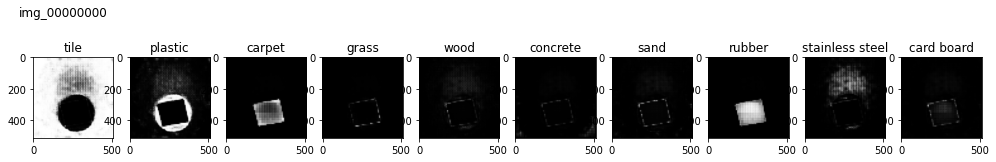

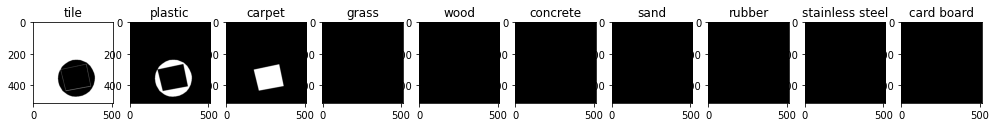

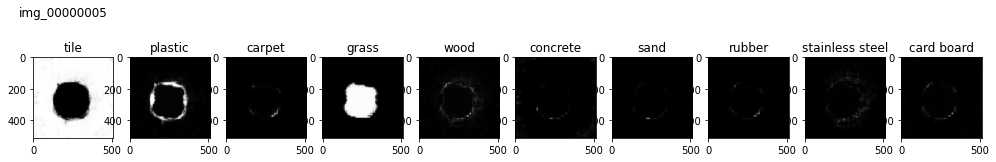

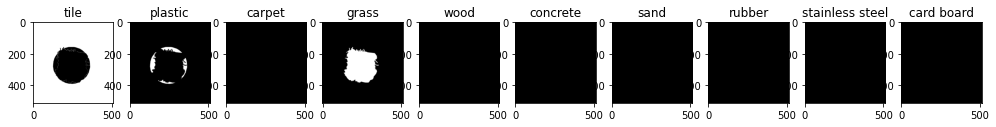

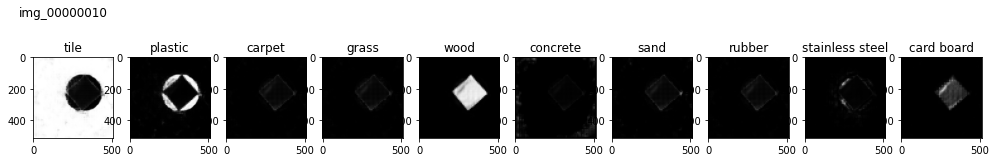

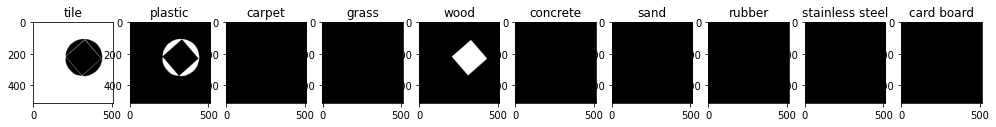

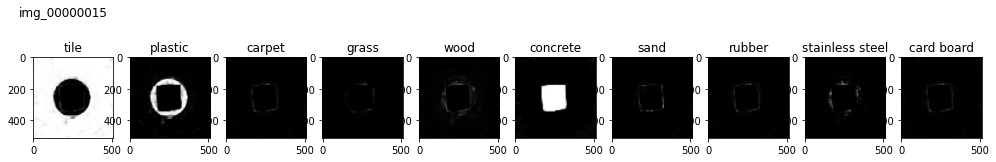

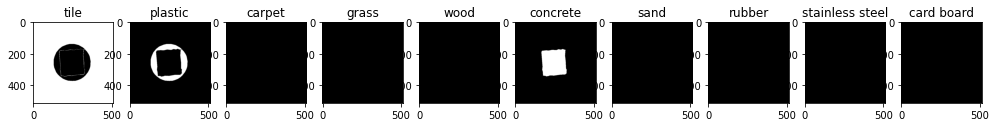

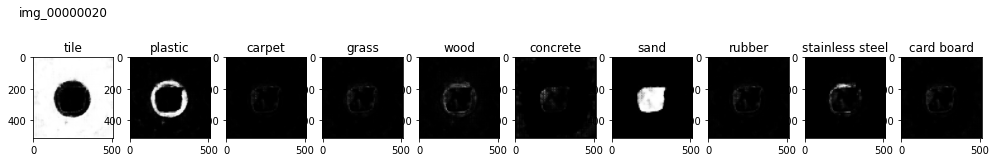

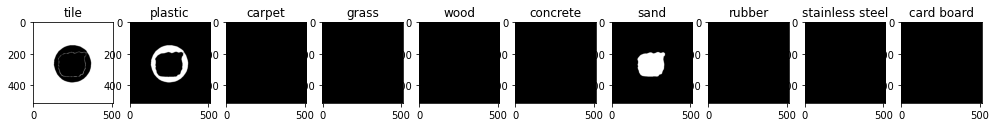

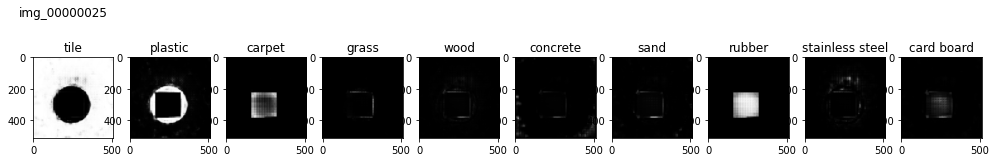

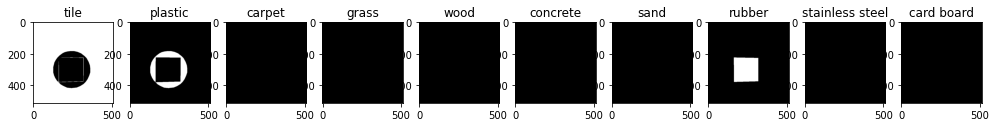

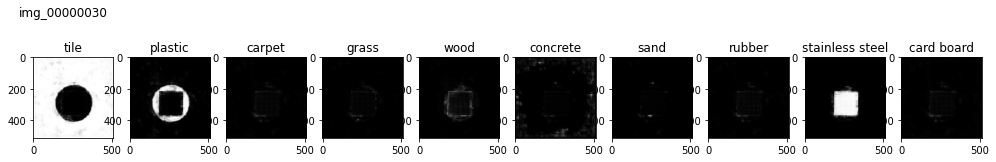

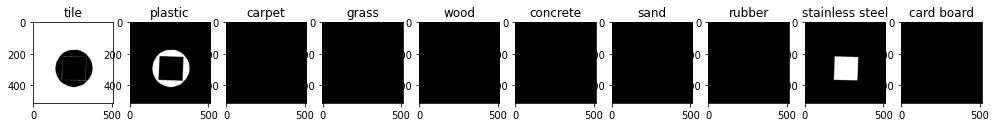

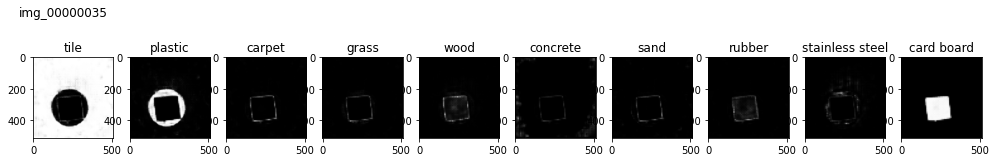

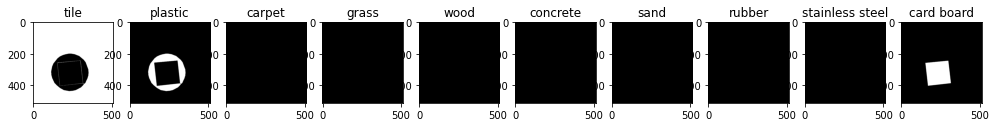

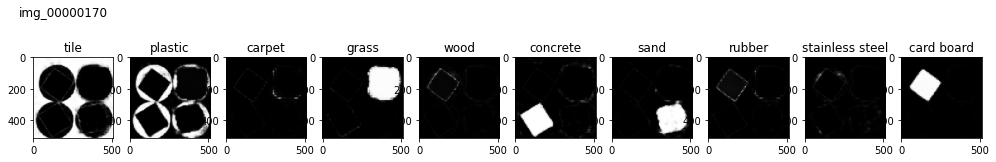

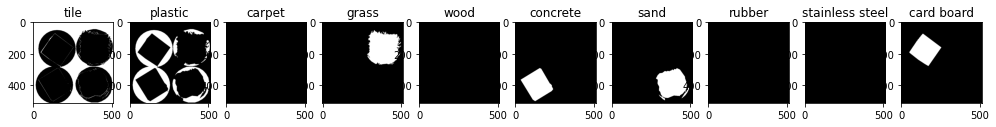

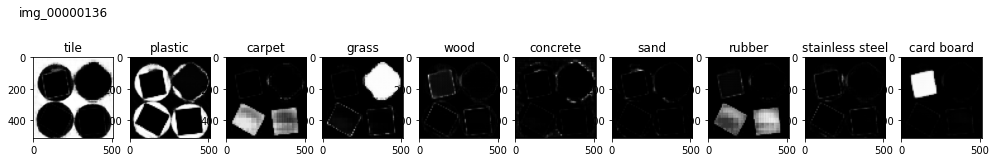

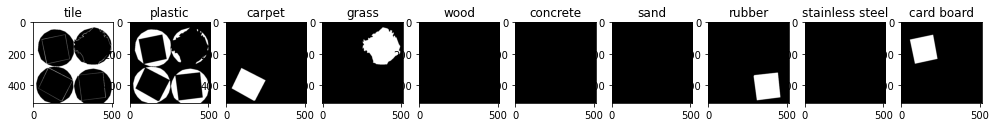

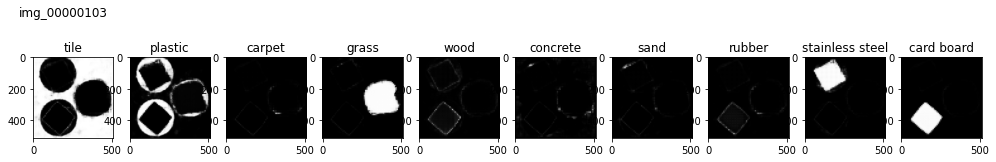

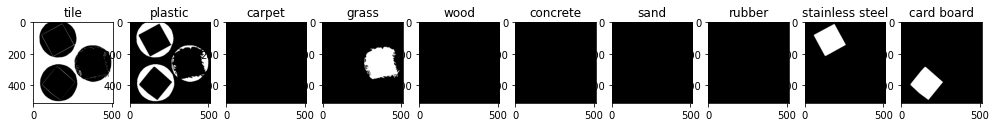

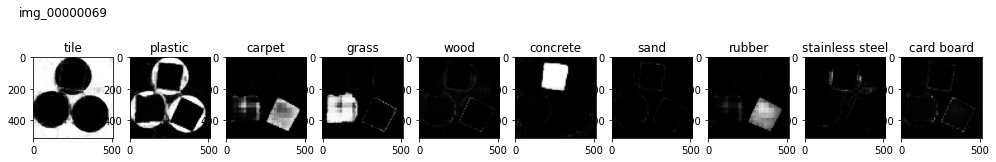

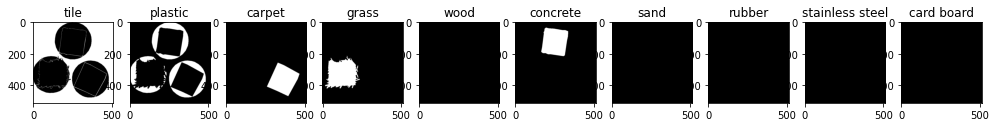

In [ ]:
# visualize prediction
print(model.name); print()
cat_index = ['tile','plastic','carpet','grass','wood','concrete','sand','rubber','stainless steel','card board']

for i in range(len(P)):
  fig = plt.figure(figsize=(17,6))
  fig.suptitle('img_'+str(testSet[i]).zfill(8),x=0.15)
  for k in range(n_classes):
      ax = fig.add_subplot(3,10,k+1)
      ax.imshow(P[i,:,:,k], cmap='gray')
      ax.set_title(cat_index[k])
  fig = plt.figure(figsize=(17,6))
  for k in range(n_classes):
      ax = fig.add_subplot(3,10,k+1)
      ax.imshow(testY[i,:,:,k], cmap='gray')
      ax.set_title(cat_index[k])
  plt.show()

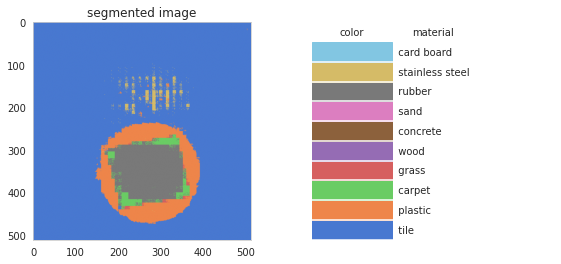

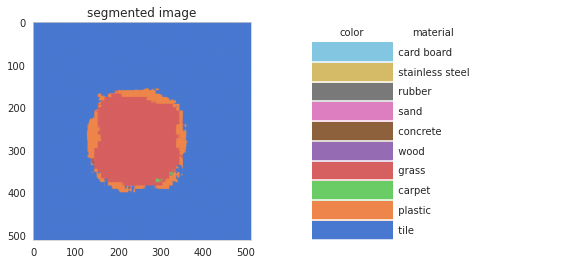

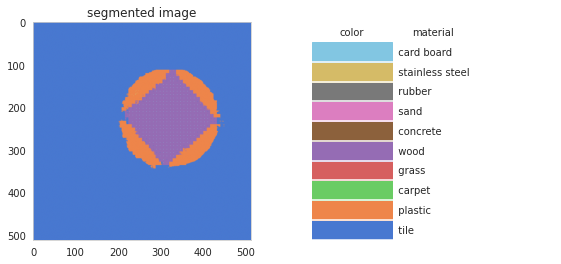

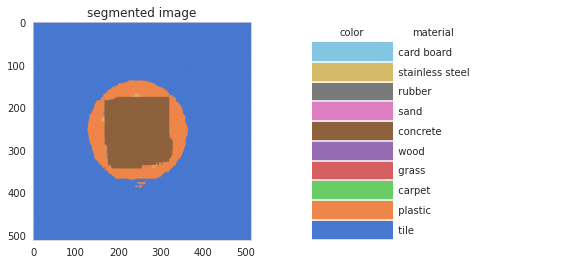

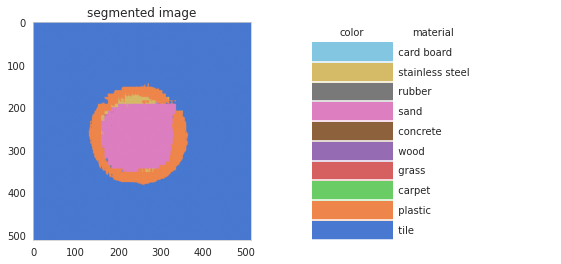

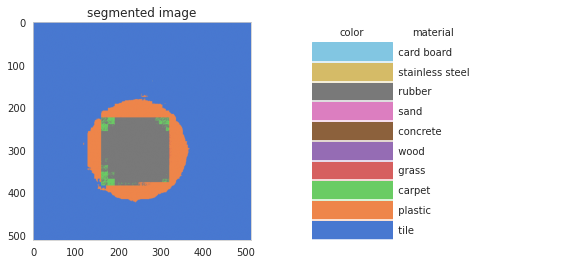

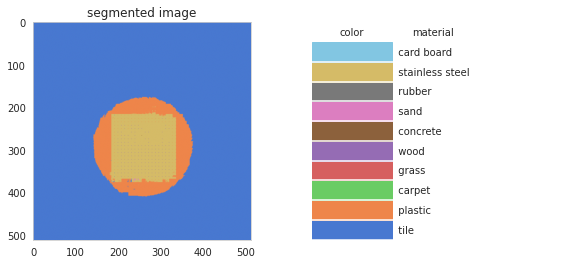

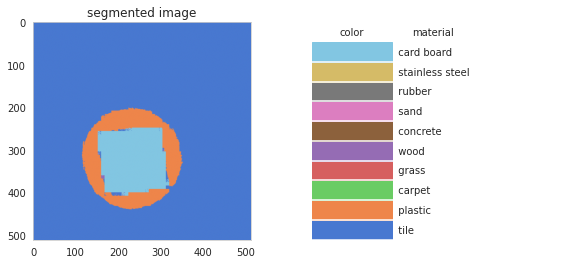

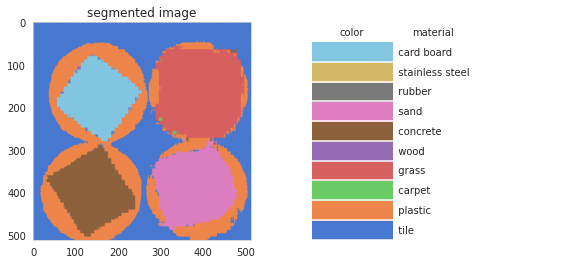

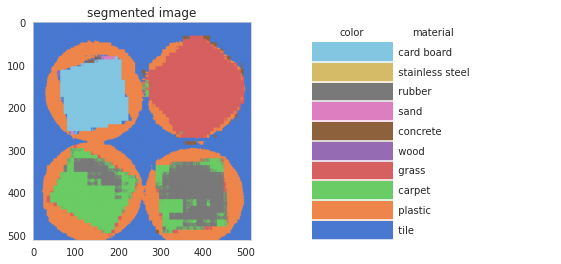

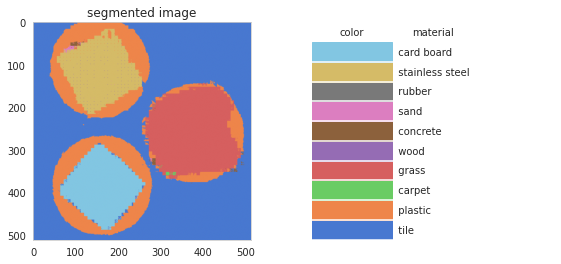

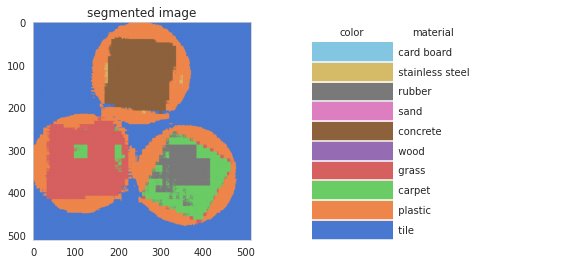

In [ ]:
import random
import seaborn as sns
import matplotlib.patches as mpatch

sns.set_style("whitegrid", {'axes.grid' : False})

def colorize(seg, n_classes):
    #return colorized image from segmentation
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("muted", n_classes)
    
    for c in range(n_classes):
        mask = (seg[:,:] == c)
        seg_img[:,:,0] += mask*colors[c][0]
        seg_img[:,:,1] += mask*colors[c][1]
        seg_img[:,:,2] += mask*colors[c][2]

    return(seg_img),colors

def displayColorResult(seg, n_classes, file_name):
  # get colorized result
  Result, colors = colorize(seg.argmax(2),n_classes=n_classes)

  # display image
  fig = plt.figure(figsize=(20,4))
  ax = fig.add_subplot(1,4,1)
  ax.imshow(Result)
  ax.set_title("segmented image")

  # display index
  ax = fig.add_subplot(1,4,2)
  cat_index = ['tile','plastic','carpet','grass','wood','concrete','sand','rubber','stainless steel','card board']
  for i in range(10):
      weight = None
      cn = (0,1,1)
      r1 = mpatch.Rectangle((0, i), 1, 1, color=colors[i])
      txt = ax.text(1, i+.5, '  '+cat_index[i], va='center', fontsize=10)
      ax.axhline(i, color=(1,1,1))
      ax.add_patch(r1)

  ax.text(.5, i + 1.5, 'color', ha='center', va='center')
  ax.text(1.5, i + 1.5, 'material', ha='center', va='center')
  ax.set_xlim(0, 3)
  ax.set_ylim(0, i + 2)
  ax.axis('off')

  # save color result
  plt.savefig(file_name)
  pltimg = cv2.imread(file_name)
  pltimg = pltimg[:,150:-780]
  cv2.imwrite(file_name,pltimg)

  plt.show()

# display
# displayColorResult(P[i],n_classes=10, "abc.png")

# store automated
import os,cv2
new_dir = "./Result"
if not os.path.exists(new_dir): os.mkdir(new_dir)
for i in range(len(P)):
  displayColorResult(P[i],n_classes=10, file_name=new_dir+"/"+str(i)+".png")

**Numerical Analysis**: See loss graph and IU value

In [ ]:
def IU_value(Y,P,mode):
    """Y and P must be same shape (nxhxwxk)"""
    if Y.shape != P.shape: return None
    n_classes = P.shape[3]

    # make tensor value either 0 or 1 from floats
    P01 = [] 
    for i in range(P.shape[0]):
        temp = P[i].argmax(2)
        mask = np.array([temp == c for c in range(n_classes)])
        P01.append(np.moveaxis(mask,0,-1))
    P01 = np.array(P01) #(nxhxwx9)

    # find intersection and union
    intersection = np.logical_and(Y, P01)
    union = np.logical_or(Y, P01)

    # calculate pixel accuracy
    if mode=="pixel_acc":
      intersection = np.logical_and(Y, P01)
      return np.sum(intersection) / np.sum(Y)

    # calculate mean accuracy
    if mode=="mean_acc":
      mean_acc = 0
      for i in range(n_classes):
        v = np.sum(intersection[:,:,:,i]) / np.sum(Y[:,:,:,i])
        mean_acc += v
      return mean_acc / n_classes
      
    # calculate mean iou
    if mode=="mean_IU":
      iou_score = 0
      for i in range(n_classes):
        v = np.sum(intersection[:,:,:,i]) / np.sum(union[:,:,:,i])
        iou_score += v
      return iou_score / n_classes
      
print("pixel_acc:",IU_value(testY,P,"pixel_acc"))
print("mean_acc:",IU_value(testY,P,"mean_acc"))
print("mean_IU:",IU_value(testY,P,"mean_IU"))

pixel_acc: 0.9728849835868827
mean_acc: 0.9547654140174486
mean_IU: 0.8974930967120187


In [ ]:
# view loss graph
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key][4:],label=key)
plt.legend()
plt.show()